# Pythonでバンディットアルゴリズム
最近、強化学習の勉強をはじめたので、その分野で有名な多腕バンディット問題を紹介していきたい。

## 多腕バンディット問題

こんな状況を考えてみる。

* 5枚のコインA, B, C, D, Eがある
* 2000回コインを投げていっぱい表を出したい
* 投げる度にコインを選んでよい
* それぞれのコインの表の出る確率は違うって噂  
（ここではA, B, C, D, Eそれぞれの表の出る確率が異なっている可能性があって、その確率は誰も知らないとする)

上記のような問題を**多腕バンディット問題(Multi-armed bandit problem)**という。
この記事では、少し遠回りしながら、実装例も含めて説明していく。

まずは、アルゴリズムを比較していくため、 データをつくっておく。  
（再現できるようにデータはつくっておきますが、結果は投げた後でしかわからないものとする。）  
またプログラムでは簡単のため、コインA, B, C, D, Eそれぞれを0, 1, 2, 3, 4とした。  

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# create datasets
np.random.seed(6)
TRIAL_NUMBER = 2000
OBVERSE_PROP = np.array([0.3, 0.4, 0.5, 0.6, 0.7])
RESULT_DATA = np.array(
   [np.random.binomial(1, p, TRIAL_NUMBER)for p in OBVERSE_PROP])
COINS = range(5)

# 例えば2000回すべてにおいて、コインAを選んだ場合の結果は次のようになる
RESULT_DATA[0]

array([1, 0, 1, ..., 1, 0, 0])

今回は、A, B, C, D, Eそれぞれの表の出る確率を0.3, 0.4, 0.5 ,0.6, 0.7として試行結果のデータをつくりました。  
ずっとコインEを選ぶと、総報酬を最大化できる設定です。


## 手法1.Greedy Algorithm

バンディット問題に対するひとつの対抗手段としてGreedy Algorithmと呼ばれるものがあります。  
名前はかっこいいですが、とても単純で、つぎの２条件からなるアルゴリズムです。

* 最初に5枚全て投げて試してみる。
* それ以降は期待値が最も高いコインを選ぶ

実装例を以下に示しましょう。

In [2]:
class Greedy(object):
    def __init__(self):
        self.rewards = dict()
        self.cnt = 0
        self.result = np.zeros(TRIAL_NUMBER)

    def get_reward(self, coin):
        return RESULT_DATA[coin][self.cnt]

    def estimate_q(self, coin):
        """説明を省きたいので、漸進的ではない方法で実装"""
        reward = self.rewards.get(coin)
        q = sum(reward) / float(len(reward)) if reward else 0
        return q

    def choice_coin(self):
        choiced_coin = np.argmax(
            [self.estimate_q(coin) for coin in COINS])
        return choiced_coin

    def first_throw(self):
        choiced_coin = np.random.choice(
            list(set(COINS) - set(self.rewards.keys())))
        self.rewards[choiced_coin] = [self.get_reward(choiced_coin)]
        self.cnt += 1

    def throw(self):
        choiced_coin = self.choice_coin()
        reward = self.get_reward(choiced_coin)
        self.rewards[choiced_coin].append(reward)
        self.result[self.cnt] = reward
        self.cnt += 1

    def execute(self):
        [self.first_throw() if i < len(COINS) else self. throw()
         for i in range(TRIAL_NUMBER)]

greedy = Greedy()
greedy.execute()


各時点での表が出た割合を見てみます。  


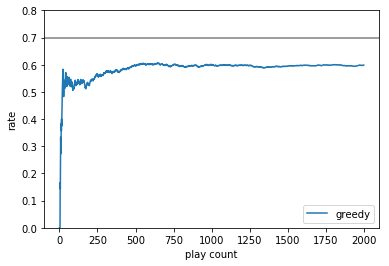

In [4]:
def verification(alg, title):
    plt.plot(np.cumsum(alg.result) / np.arange(1, TRIAL_NUMBER+1),label=title)
    plt.legend(loc='lower right')
    plt.axhline(y=0.7, color='gray')
    plt.xlabel('play count')
    plt.ylabel('rate')
    plt.ylim(0, 0.8)
    plt.show()

verification(greedy, 'greedy')

Greedy algorithmの結果が上のようになりました。  
最初の段階でコインEの結果が良くなかったために、コインDを投げ続けるという選択をとってしまっています。  

### Greedy algorithmの特徴

Greedy algorithmは次のような特徴をもっています。

* 最初の段階で珍しいことが起こってしまうと、その後すべての行動に響いてしまう。
* 報酬の分散がゼロであれば、効率的

### 強化学習とは

ちょっとここで強化学習の説明をいれておきます。  
強化学習では試行錯誤しながら、総報酬を最大化することが目的です。そのために、基本的に２つのことを考えます。

**知識の利用（exploitation）**
現時点で、最も表がでそうなコインを投げる。

**探索(exploration)**
表ばっかりでる夢のコインを探す。そういうコインが見つかれば最終的には得するかもしれない。

強化学習ではトレードオフの関係にある利用と探索をうまいこと混ぜ合わせて、総報酬を最大化していきます。  
先ほどの例では探索を十分に行わなかったため、2000回時点での表が出た割合が6割程度にとどまっています。  
かといって探索をしすぎてもよくないところが多腕バンディット問題の難しさですね。

### 手法2. ε-Greedy algorithm

ε-Greedy algorithmはGreedy algorithmを改良したもので、永遠に、ある確率εで探索を続けていくようなアルゴリズムです。

* 確率εで探索を行う（ランダムでコインを選ぶ)
* 確率1-εで最も良いと思われるコインを選ぶ

Greedy algorithmはε=0のε-Greedy algorithmということになります。  
Greedyクラスをもとにして確率εで探索をおこなうように変更してみます。  

In [5]:
class EpsilonGreedy(Greedy):
    def __init__(self, epsilon):
        self.epsilon = epsilon
        super(EpsilonGreedy, self).__init__()

    def choice_coin(self):
        is_random = np.random.choice(
            2, 1, p=[1 - self.epsilon, self.epsilon])[0]
        choiced_coin = (np.random.choice(COINS) if is_random else
                        np.argmax([self.estimate_q(coin) for coin in COINS]))
        return choiced_coin

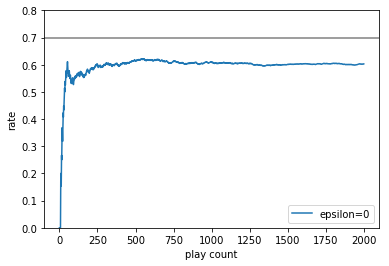

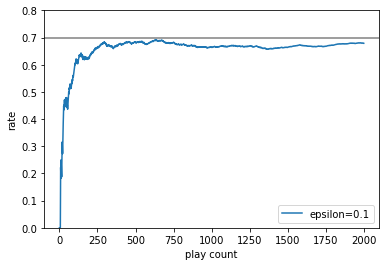

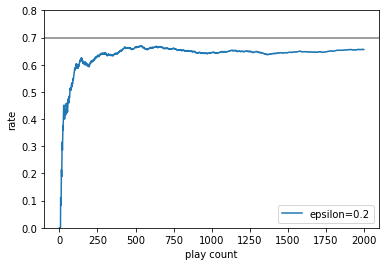

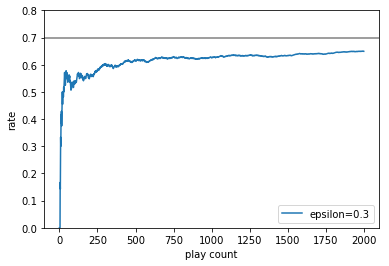

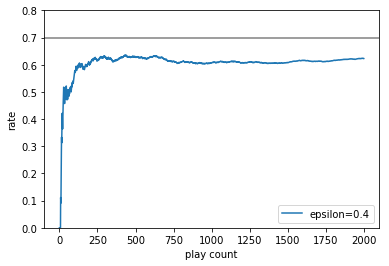

[None, None, None, None, None]

In [6]:
epsilons = [0, 0.1, 0.2, 0.3, 0.4]
epsilon_greedy_list = [EpsilonGreedy(epsilon) for epsilon in epsilons]
[eg.execute() for eg in epsilon_greedy_list]
[verification(eg, 'epsilon='+str(eg.epsilon)) for eg in epsilon_greedy_list]

Greedy algorithmのときよりも良い結果が出てきました。（この場合はですが）

### ε-Greedy algorithmの特徴

* 報酬の分散が大きければ、より多くの探査が必要になるので、Greedy algorithmよりも良い性能を示す
* 分散がゼロであれば、無駄な探査が少ない分、Greedy algorithmが良い性能を示す
* εが小さければ良いコインを見つけるのに時間がかかってしまう
* εが大きければ早く良いコインを見つけられるが、その後の探索が無駄になってしまう

### 手法3. Softmax Action Selection

ε-Greedy algorithmは探索を行う際にランダムにコインを選んでいました。  
それに対して、ソフトマックス手法では良いと思われるコインを高確率で選択し、悪いと思われるコインを低確率で選択します。  
このアルゴリズムでは温度と呼ばれる正定数tauを設定してすることにより、選択確率を調整していて、次の性質があります。

* 温度が高ければ探索中心
* 温度が低ければ活用中心

具体的にはGibbs分布と呼ばれる分布を用いて行動aの選択確率を次のように定めます。  
exp(Q(a)/tau)/Z (ただし、Zはとりうる行動bについてのexp(Q(b)/tau)のsum）

これをふまえてまた実装してみます。

In [7]:
class SoftmaxActionSelection(Greedy):
    def __init__(self, tau):
        self.tau = tau
        return super(SoftmaxActionSelection, self).__init__()
 
    def choice_coin(self):
        q = np.array([self.estimate_q(coin) for coin in COINS])
        if np.sum(q) == 0:
            q = np.ones(len(self.actions))
        g = np.exp(q / self.tau) / sum(np.exp(q / self.tau))
        choiced_coin = np.random.choice(COINS, p=g)
        return choiced_coin

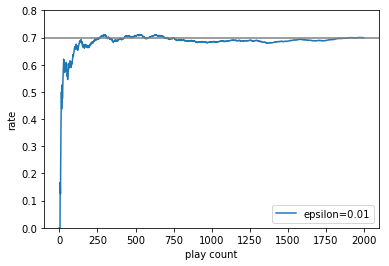

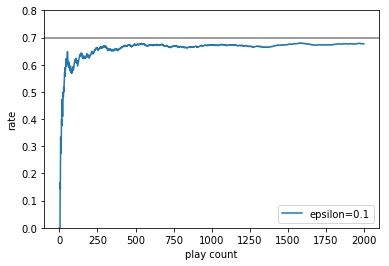

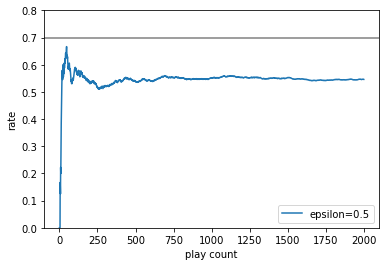

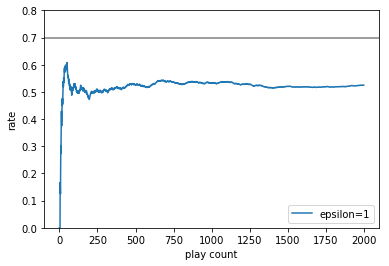

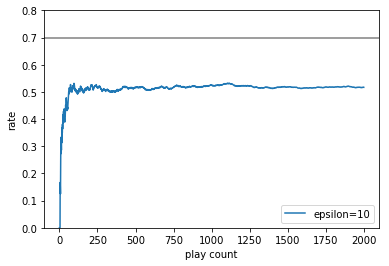

[None, None, None, None, None]

In [8]:
taus = [0.01, 0.1, 0.5, 1, 10]
softmax_list = [SoftmaxActionSelection(tau) for tau in taus]
[sm.execute() for sm in softmax_list]
[verification(sm, 'epsilon='+str(sm.tau)) for sm in softmax_list]

うまくtauを設定できたものはε-Greedy algorithmと同じような結果になっています。(この場合ですが）

**Softmax Action Selectionの特徴**

* tauの設定が難しい
* 確信度が考慮されていない（ε-Greedy algorithmも同様）

### まとめ

今回は３つのアルゴリズムを紹介しましたが、 この他にもUCB系アルゴリズムやcontextual banditとよばれる手法があります。 UCB系アルゴリズムでは確信度を考慮し、最適な期待報酬値に漸近していく手法です。  
また、contextual banditは線形モデル等のモデルを加味して最適化していくそうなのですが、僕はまだよくわかってません。